<a href="https://colab.research.google.com/github/Shalha-Mucha18/Convolutional-Neural-Network-CNN-/blob/main/Burgers'_equation_solving_using_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import some libaries
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io 
import random
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
import torch.nn as nn

In [5]:
#import data from  file
dataset=scipy.io.loadmat('/content/burgers_shock.mat')

In [6]:
#showing some data
dataset['x'][1:10]

array([[-0.99215686],
       [-0.98431373],
       [-0.97647059],
       [-0.96862745],
       [-0.96078431],
       [-0.95294118],
       [-0.94509804],
       [-0.9372549 ],
       [-0.92941176]])

In [7]:
#finding the  shape
print("Size of x :",len(dataset['x']))
print("Size of t :",len(dataset['t']))
print('Number of points:',len(dataset['x']) *len(dataset['t']))
print('Image Dimension :',dataset['usol'].shape)

Size of x : 256
Size of t : 100
Number of points: 25600
Image Dimension : (256, 100)


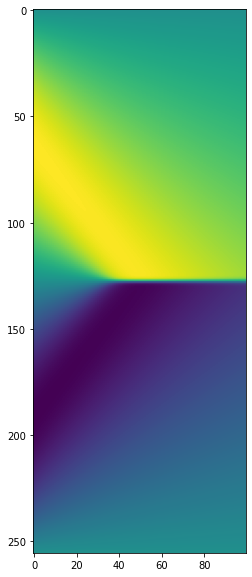

In [8]:
#ploting the solution
fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(dataset['usol'])
plt.show()

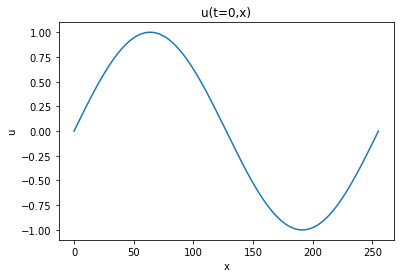

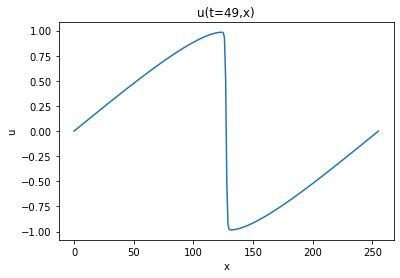

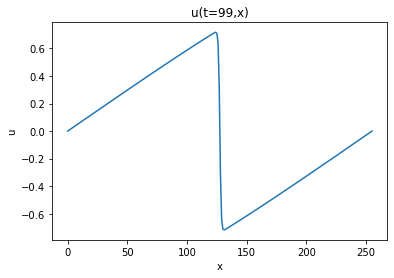

In [9]:
tt=np.linspace(0,len(dataset['t'])-1, 3, dtype=int)
for i in tt:
  plt.plot(dataset['usol'][:,i])
  plt.title("u(t=" +str(i) +",x)")
  plt.xlabel('x')
  plt.ylabel('u')
  plt.show()


In [10]:
# Data Preprocesing
def split_data(data=dataset,tr_n=2000):
  u_tr = []
  x_tr = [] 
  t_tr = []

  u_te = []                                
  x_te = []
  t_te = []

  prob = tr_n / (data['usol'].shape[0]*data['usol'].shape[1])
  for x,u_t in zip(data['x'],data['usol']):
    x=x[0]
    for t,u in zip(data['t'],u_t):
      t=t[0]
      if random.random()>prob:
         u_te.append([u])
         x_te.append([x])
         t_te.append([t])
      else:
        u_tr.append([u])
        x_tr.append([x])
        t_tr.append([t])    
  x_tr = torch.tensor(x_tr, requires_grad=True).float()
  x_te = torch.tensor(x_te, requires_grad=True).float()
  t_tr = torch.tensor(t_tr, requires_grad=True).float()
  t_te = torch.tensor(t_te, requires_grad=True).float()
  u_tr = torch.tensor(u_tr).float()
  u_te = torch.tensor(u_te).float()   
  return [x_tr, t_tr, u_tr], [x_te, t_te, u_te]   


In [11]:
#spliting the data
device = 'cuda'
train, test = split_data(data=dataset, tr_n=2000)
x_train = train[0].to(device)
t_train = train[1].to(device)
u_train = train[2].to(device)
x_test = test[0]
t_test = test[1]
u_test = test[2]

In [12]:
#create a Dense Neural Network that predict u(x,t)
class DNN(nn.Module):
  def __init__(self):
        super(DNN, self).__init__()

        #Inpunt Layer
        self.linear1 = nn.Linear(2, 20)
        #Dense layer
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 20)
        self.linear4 = nn.Linear(20, 20)
        self.linear5 = nn.Linear(20, 20)
        self.linear6 = nn.Linear(20, 20)
        self.linear7 = nn.Linear(20, 20)
        self.linear8 = nn.Linear(20, 20)
        self.linear9 = nn.Linear(20, 20)
        #output layer
        self.linear10 = nn.Linear(20, 1)

        #activation function
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        self.tanh4 = nn.Tanh()
        self.tanh5 = nn.Tanh()
        self.tanh6 = nn.Tanh()
        self.tanh7 = nn.Tanh()
        self.tanh8 = nn.Tanh()
        self.tanh9 = nn.Tanh()
    #forward
  def forward(self,x):
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        x = self.linear4(x)
        x = self.tanh4(x)
        x = self.linear5(x)
        x = self.tanh5(x)
        x = self.linear6(x)
        x = self.tanh6(x)
        x = self.linear7(x)
        x = self.tanh7(x)
        x = self.linear8(x)
        x = self.tanh8(x)
        x = self.linear9(x)
        x = self.tanh9(x)
        x = self.linear10(x)

        return x      

In [13]:
#build the  PINN
class PINN():
  def __init__(self,x,t,u,l1=0.0,l2=-6.0):
    self.x=x.to(device)
    self.t=t.to(device)
    self.u = u.to(device) 
    #given the 2 extra parameters  l1  and  l2, and give them a initial value
    self.lambda_1=torch.tensor([l1],requires_grad=True).to(device)
    self.lambda_2 = torch.tensor([l2], requires_grad=True).to(device)

    self.lambda_1 = torch.nn.Parameter(self.lambda_1)
    self.lambda_2 = torch.nn.Parameter(self.lambda_2)

    #intialize the DNN class
    self.dnn = DNN().to(device)
    self.dnn.register_parameter('lambda_1', self.lambda_1)
    self.dnn.register_parameter('lambda_2', self.lambda_2)

    #optimizer
    self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=0.0001, betas=(0.9, 0.999))
    self.iter = 0
    #calculate the Burgers equation
  def berger_ec(self,u):
      lambda_1 = self.lambda_1 
      lambda_2 = torch.exp(self.lambda_2)
      diff_x = torch.autograd.grad(u, self.x, grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
      diff_t = torch.autograd.grad(u, self.t, grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
      diff_xx = torch.autograd.grad(diff_x, self.x, grad_outputs=torch.ones_like(diff_x),retain_graph=True,create_graph=True)[0]
      return  diff_t + self.lambda_1 * u * diff_x -  torch.exp(self.lambda_2) * diff_xx
    #predict the value
  def pred_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u   
    # define the loss function
  def loss_function(self):
        u_pred = self.pred_u(self.x, self.t)
        f_pred = self.berger_ec(u_pred)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer_Adam.zero_grad()
        loss.backward()
    #train function
  def train(self, n_epochs=0):
      self.dnn.train()
      Loss = [] 
      for epoch in range(n_epochs): 
        u_pred = self.dnn(torch.cat([self.x, self.t], dim=1))
        f_pred = self.berger_ec(u_pred)   
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer_Adam.zero_grad()
        loss.backward()
        self.optimizer_Adam.step()
        Loss.append(loss.item())
        if epoch%20 == 0:  
                print( 'Epoch: ', epoch, ' => ', 'Loss: ',  loss.item())
      self.optimizer_Adam.step(self.loss_function)
      return self.dnn.to('cpu')


In [14]:
#Train the model
model = PINN(x_train, t_train, u_train)
dnn = model.train(1000)

Epoch:  0  =>  Loss:  0.3633694648742676
Epoch:  20  =>  Loss:  0.36161544919013977
Epoch:  40  =>  Loss:  0.36082392930984497
Epoch:  60  =>  Loss:  0.3598537743091583
Epoch:  80  =>  Loss:  0.35806894302368164
Epoch:  100  =>  Loss:  0.35419031977653503
Epoch:  120  =>  Loss:  0.34567949175834656
Epoch:  140  =>  Loss:  0.32827556133270264
Epoch:  160  =>  Loss:  0.2974548637866974
Epoch:  180  =>  Loss:  0.25606653094291687
Epoch:  200  =>  Loss:  0.22384661436080933
Epoch:  220  =>  Loss:  0.21233077347278595
Epoch:  240  =>  Loss:  0.20769740641117096
Epoch:  260  =>  Loss:  0.20342035591602325
Epoch:  280  =>  Loss:  0.1984543800354004
Epoch:  300  =>  Loss:  0.1926538199186325
Epoch:  320  =>  Loss:  0.18588590621948242
Epoch:  340  =>  Loss:  0.17810489237308502
Epoch:  360  =>  Loss:  0.16940821707248688
Epoch:  380  =>  Loss:  0.16008183360099792
Epoch:  400  =>  Loss:  0.1505621373653412
Epoch:  420  =>  Loss:  0.14131075143814087
Epoch:  440  =>  Loss:  0.13267897069454193


In [15]:
#Test the model
u_pred = dnn(torch.cat([x_test, t_test], dim=1))
error = np.linalg.norm(u_test-u_pred.detach().cpu().numpy(),2)/np.linalg.norm(u_test,2)
print("model error:",error)

model error: 0.31792971
